In [31]:
import tensorflow as tf
from tensorflow import keras

import numpy as np

In [2]:
batch_size = 128
num_classes = 10
epochs = 12

In [3]:
# input image dimensions
img_rows, img_cols = 28, 28

In [8]:
# the data, split between train and test sets
(x_train, y_train), (x_test, y_test) = keras.datasets.mnist.load_data()

In [16]:
x_train = x_train.reshape(x_train.shape[0], img_rows, img_cols, 1)
x_test = x_test.reshape(x_test.shape[0], img_rows, img_cols, 1)
input_shape = (img_rows, img_cols, 1)

x_train = x_train.astype('float32')
x_test = x_test.astype('float32')
x_train /= 255
x_test /= 255
print('x_train shape:', x_train.shape)
print(x_train.shape[0], 'train samples')
print(x_test.shape[0], 'test samples')

# convert class vectors to binary class matrices
y_train = keras.utils.to_categorical(y_train, num_classes)
y_test = keras.utils.to_categorical(y_test, num_classes)

x_train shape: (60000, 28, 28, 1)
60000 train samples
10000 test samples


In [11]:
model = keras.models.Sequential()
model.add(keras.layers.Conv2D(32, kernel_size=(3, 3),
                 activation='relu',
                 input_shape=input_shape))
model.add(keras.layers.Conv2D(64, (3, 3), activation='relu'))
model.add(keras.layers.MaxPooling2D(pool_size=(2, 2)))
model.add(keras.layers.Dropout(0.25))
model.add(keras.layers.Flatten())
model.add(keras.layers.Dense(128, activation='relu'))
model.add(keras.layers.Dropout(0.5))
model.add(keras.layers.Dense(num_classes, activation='softmax'))

model.compile(loss=keras.losses.categorical_crossentropy,
              optimizer=keras.optimizers.Adadelta(),
              metrics=['accuracy'])

In [6]:
model.fit(x_train, y_train,
          batch_size=batch_size,
          epochs=epochs,
          validation_data=(x_test, y_test))

Train on 60000 samples, validate on 10000 samples
Epoch 1/12
60000/60000 [==============================] - 7s 121us/step - loss: 0.2557 - acc: 0.9219 - val_loss: 0.0561 - val_acc: 0.9821
Epoch 2/12
60000/60000 [==============================] - 2s 37us/step - loss: 0.0860 - acc: 0.9742 - val_loss: 0.0478 - val_acc: 0.9841
Epoch 3/12
60000/60000 [==============================] - 2s 38us/step - loss: 0.0647 - acc: 0.9807 - val_loss: 0.0347 - val_acc: 0.9879
Epoch 4/12
60000/60000 [==============================] - 2s 39us/step - loss: 0.0542 - acc: 0.9840 - val_loss: 0.0295 - val_acc: 0.9893
Epoch 5/12
60000/60000 [==============================] - 2s 39us/step - loss: 0.0459 - acc: 0.9861 - val_loss: 0.0313 - val_acc: 0.9895
Epoch 6/12
60000/60000 [==============================] - 2s 39us/step - loss: 0.0410 - acc: 0.9879 - val_loss: 0.0265 - val_acc: 0.9904
Epoch 7/12
60000/60000 [==============================] - 2s 40us/step - loss: 0.0373 - acc: 0.9883 - val_loss: 0.0263 - val_ac

In [7]:
score = model.evaluate(x_test, y_test, verbose=0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

Test loss: 0.025907322766340803
Test accuracy: 0.9917


In [14]:
p_model = keras.utils.multi_gpu_model(model, gpus=2, cpu_merge=False)
p_model.compile(loss=keras.losses.categorical_crossentropy,
              optimizer=keras.optimizers.Adadelta(),
              metrics=['accuracy'])

In [17]:
p_model.fit(x_train, y_train,
          batch_size=batch_size * 2,
          epochs=epochs,
          validation_data=(x_test, y_test))

Train on 60000 samples, validate on 10000 samples
Epoch 1/12
60000/60000 [==============================] - 4s 70us/step - loss: 0.3472 - acc: 0.8905 - val_loss: 0.0752 - val_acc: 0.9759
Epoch 2/12
60000/60000 [==============================] - 2s 28us/step - loss: 0.1029 - acc: 0.9699 - val_loss: 0.0517 - val_acc: 0.9835
Epoch 3/12
60000/60000 [==============================] - 2s 28us/step - loss: 0.0749 - acc: 0.9773 - val_loss: 0.0374 - val_acc: 0.9869
Epoch 4/12
60000/60000 [==============================] - 2s 28us/step - loss: 0.0630 - acc: 0.9805 - val_loss: 0.0334 - val_acc: 0.9881
Epoch 5/12
60000/60000 [==============================] - 2s 30us/step - loss: 0.0526 - acc: 0.9839 - val_loss: 0.0322 - val_acc: 0.9889
Epoch 6/12
60000/60000 [==============================] - 2s 26us/step - loss: 0.0464 - acc: 0.9859 - val_loss: 0.0314 - val_acc: 0.9899
Epoch 7/12
60000/60000 [==============================] - 2s 26us/step - loss: 0.0407 - acc: 0.9874 - val_loss: 0.0313 - val_acc

In [67]:
vgg19 = keras.applications.vgg19.VGG19(weights=None, include_top=True, classes=num_classes, input_shape=(224, 224, 1))

In [68]:
p_vgg19 = keras.utils.multi_gpu_model(vgg19, gpus=2, cpu_merge=False)
p_vgg19.compile(loss=keras.losses.categorical_crossentropy,
              optimizer=keras.optimizers.Adadelta(),
              metrics=['accuracy'])

In [69]:
class MnistSequence(keras.utils.Sequence):
    def __init__(self, X, y, batch_size, mode='train', image_size=(224, 224), channels=1):
        self.X = X
        self.y = y
        self.batch_size = batch_size
        self.mode = mode
        self.image_size = image_size
        self.channels = channels
        
        self.indexes = np.arange(len(self.X))
        
        self.on_epoch_end()
    
    def __len__(self):
        return int(np.floor(len(self.indexes) / self.batch_size))
    
    def __getitem__(self, index):
        indexes = self.indexes[index * self.batch_size : (index + 1) * self.batch_size]
        
        X, y = self.__data_generation(indexes)
        
        return X, y
    
    def on_epoch_end(self):
        self.indexes = np.arange(len(self.indexes))
        if self.mode == 'train':
            np.random.shuffle(self.indexes)
            
            
    def __data_generation(self, indexes):
        X = np.empty((self.batch_size, *self.image_size, self.channels), dtype='float32')
        y = np.empty((self.batch_size, self.y.shape[1]), dtype=int)
        
        for i, idx in enumerate(indexes):
            img = keras.preprocessing.image.array_to_img(self.X[idx])
            img = img.resize(self.image_size)
            img = keras.preprocessing.image.img_to_array(img)

            if self.mode == 'train':
                img = keras.preprocessing.image.random_rotation(img, rg=5)
                img = keras.preprocessing.image.random_shear(img, intensity=0.05)
                img = keras.preprocessing.image.random_zoom(img, zoom_range=(0.95, 1.05))

            img = keras.preprocessing.image.img_to_array(img)
            img = img.astype('float32')
            img /= 255

            X[i] = img
            y[i] = self.y[idx]
    
        return X, y

In [82]:
ex_X, ex_y = MnistSequence(x_train, y_train, batch_size=1, mode='train')[0]

In [83]:
import matplotlib.pyplot as plt

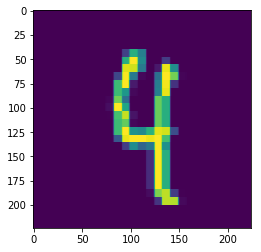

In [84]:
plt.imshow(ex_X[0][:, :, 0])

In [86]:
p_vgg19.fit_generator(
    generator=MnistSequence(x_train, y_train, batch_size=batch_size * 2, mode='train'),
    epochs=epochs,
    validation_data=MnistSequence(x_test, y_test, batch_size=batch_size * 2, mode='test')
)

Epoch 1/12
234/234 [==============================] - 1160s 5s/step - loss: 2.3013 - acc: 0.1123 - val_loss: 2.3011 - val_acc: 0.1135
Epoch 2/12
234/234 [==============================] - 1201s 5s/step - loss: 2.3013 - acc: 0.1124 - val_loss: 2.3011 - val_acc: 0.1135
Epoch 3/12
 45/234 [====>.........................] - ETA: 15:21 - loss: 2.3017 - acc: 0.1109

KeyboardInterrupt: 